In [1]:
import gzip
import pickle

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import anndata as ad
import scanpy as sc
import episcanpy as epi

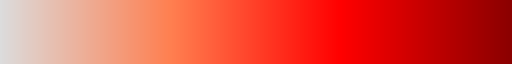

In [2]:
colors = ["gainsboro", "coral", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)
cmap

In [3]:
def tss_enrichment_score_plot(adata, threshold=None, figsize=(4, 6), save=None):
    """
    Plots a violin plot of the individual TSS enrichment scores

    Args:
        adata: AnnData
        figsize: size of the figure
        save: if True or str, save the figure. str is appended to the default filename. infer filetype if ending on {'.pdf', '.png', '.svg'}

    Returns:
        None
    """

    import seaborn as sns
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    sns.violinplot(y=adata.obs.tss_enrichment_score, inner=None, cut=0, ax=ax)
    
    if not threshold:
        sns.stripplot(y=adata.obs.tss_enrichment_score, size=1, jitter=0.3, color="black", ax=ax)
    else:
        sns.stripplot(y=adata[adata.obs.tss_enrichment_score >= threshold, :].obs.tss_enrichment_score, size=1, jitter=0.4, color="black", ax=ax)
        sns.stripplot(y=adata[adata.obs.tss_enrichment_score < threshold, :].obs.tss_enrichment_score, size=1, jitter=0.4, color="red", ax=ax)
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1, alpha=1)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_ylabel("TSS enrichment score")
    ax.set_title("TSS enrichment", loc="center")

    sns.despine()

    if not save:
        plt.show()

    else:
        default_filename = "tss_enrichment_score"

        if isinstance(save, str):

            if save[-4:] in {".pdf", ".png", ".svg"}:
                filename = default_filename + save

            else:
                filename = default_filename + save + ".png"

        else:
            filename = default_filename + ".png"

        plt.savefig(filename)

In [4]:
def pl_pc_nfeat_corr(adata, pcs=1, key="n_counts", max_cols=5, save=False):
    nrows = int(np.ceil(pcs / max_cols))
    ncols = int(pcs if pcs <= max_cols else max_cols)
    
    fig, axs = plt.subplots(figsize=(ncols * 5, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=True)
    axs = axs.flatten()
    
    for ax in axs[pcs:]:
        ax.remove()

    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(pcs):
        ax = axs[i]        

        ax.scatter(x=adata.obsm["X_pca"][:, i],
                   y=adata.obs[key],
                   s=12 - np.log10(adata.X.shape[0]),
                   alpha=0.7)

        ax.set_xticks([])
        ax.set_xlabel("PC{}".format(i + 1))
        if (i + 1) % max_cols == 1:
            ax.set_ylabel(key)
        
        ax.grid(b=False, axis="both")
        ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()

In [5]:
name = "GSM3722056"

base_dir = "/home/ph/data/temporary/for_katia_akshaya/"

fig_dir = base_dir + "{}/".format(name)
sc.settings.figdir = fig_dir

peak_matrix = base_dir + "{}_peaks.h5ad".format(name)
peak_file = base_dir + "{}_peaks.narrowPeak".format(name)
fragments_file = base_dir + "GSM3722056_SU006_Total_Post_fragments_sorted.tsv.gz"

gtf_file = "/home/ph/data/gtfs/gencode.v39lift37.basic.annotation.gtf.gz"
gtf_file_uncompr = "/home/ph/data/gtfs/gencode.v39lift37.basic.annotation.gtf"

In [6]:
list_of_barcodes = pd.read_csv("{}SU006_Post_final_cluster_order.csv".format(base_dir))
list_of_barcodes["bc"] = [bc.replace("cell-", "") for bc in list_of_barcodes.x]
list_of_barcodes

,x,bc
0,cell-GAACCGCGTGCAGACA-1,GAACCGCGTGCAGACA-1
1,cell-CTCAGAAAGAGGCGGA-1,CTCAGAAAGAGGCGGA-1
2,cell-AGATTCGGTTAAGGGC-1,AGATTCGGTTAAGGGC-1
3,cell-GCTGCGAGTCACTCTC-1,GCTGCGAGTCACTCTC-1
4,cell-GGTCATACACGATTAC-1,GGTCATACACGATTAC-1
...,...,...
197,cell-TAGTCCCCATCAACTG-1,TAGTCCCCATCAACTG-1
198,cell-CACTAAGGTCACCGCA-1,CACTAAGGTCACCGCA-1
199,cell-GGAGAACTCCAGGCCA-1,GGAGAACTCCAGGCCA-1
200,cell-TACTCGCAGAATCAGT-1,TACTCGCAGAATCAGT-1


<br><br><br><hr><br><br><br>

In [7]:
adata_atac = ad.read_h5ad(peak_matrix)

adata_atac

AnnData object with n_obs × n_vars = 154714 × 52598

In [8]:
epi.tl.find_genes(adata_atac,
                  gtf_file=gtf_file_uncompr,
                  key_added="transcript_annotation",
                  upstream=5000,
                  feature_type="transcript",
                  annotation="HAVANA",
                  raw=True)

epi.tl.find_genes(adata_atac,
                  gtf_file=gtf_file_uncompr,
                  key_added="gene_annotation",
                  upstream=5000,
                  feature_type="gene",
                  annotation="HAVANA",
                  raw=True)

<br><br><br><hr><br><br><br>

In [9]:
adata_atac = adata_atac[adata_atac.obs.index.isin(list_of_barcodes.bc.values)].copy()
adata_atac

AnnData object with n_obs × n_vars = 202 × 52598
    var: 'transcript_annotation', 'gene_annotation'

In [10]:
print(np.max(adata_atac.X))

if np.max(adata_atac.X) > 1:
    epi.pp.binarize(adata_atac)
    
print(np.max(adata_atac.X))

410.0
1.0


In [11]:
adata_atac.var["n_cells"] = np.ravel(adata_atac.X.sum(axis=0))
adata_atac.var["log_n_cells"] = np.log10(adata_atac.var.n_cells)

adata_atac.obs["n_features"] = np.ravel(adata_atac.X.sum(axis=1))
adata_atac.obs["log_n_features"] = np.log10(adata_atac.obs.n_features)

In [12]:
print(adata_atac.n_obs, adata_atac.n_vars)
adata_atac = adata_atac[adata_atac.obs.n_features > 0, :].copy()
adata_atac = adata_atac[:, adata_atac.var.n_cells > 0].copy()
print(adata_atac.n_obs, adata_atac.n_vars)

202 52598
202 50535


In [13]:
adata_atac.var["n_cells"] = np.ravel(adata_atac.X.sum(axis=0))
adata_atac.var["log_n_cells"] = np.log10(adata_atac.var.n_cells)

adata_atac.obs["n_features"] = np.ravel(adata_atac.X.sum(axis=1))
adata_atac.obs["log_n_features"] = np.log10(adata_atac.obs.n_features)

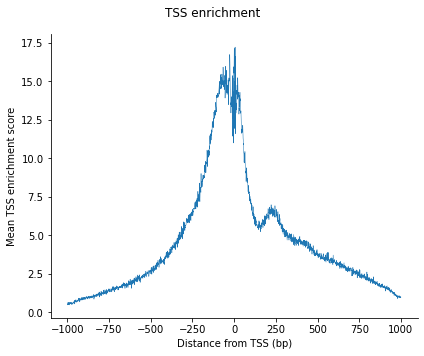

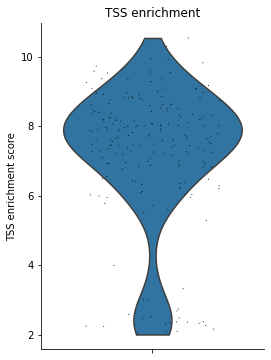

In [14]:
epi.pp.tss_enrichment(adata_atac, gtf=gtf_file, fragments=fragments_file, 
                      method="standard", score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100,
                      n_jobs=2)

epi.pl.tss_enrichment(adata_atac, save="_profile.png")
tss_enrichment_score_plot(adata_atac)

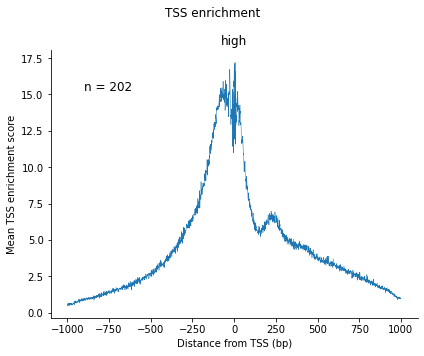

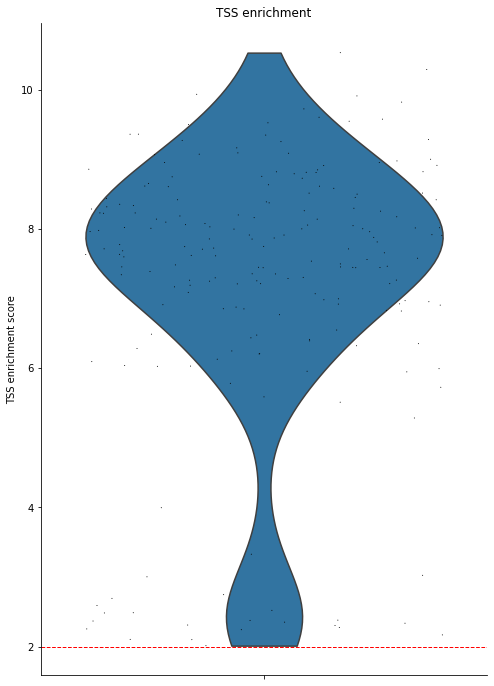

In [15]:
min_tss_score = 2

adata_atac.obs["tss_high"] = ["high" if score > min_tss_score else "low" for score in adata_atac.obs.tss_enrichment_score]
epi.pl.tss_enrichment(adata_atac, group_by="tss_high", show_n=True, max_cols=2, figsize=None, save="_profile_stratified.png")
tss_enrichment_score_plot(adata_atac, threshold=min_tss_score, figsize=(8, 12), save="_stratified.png")

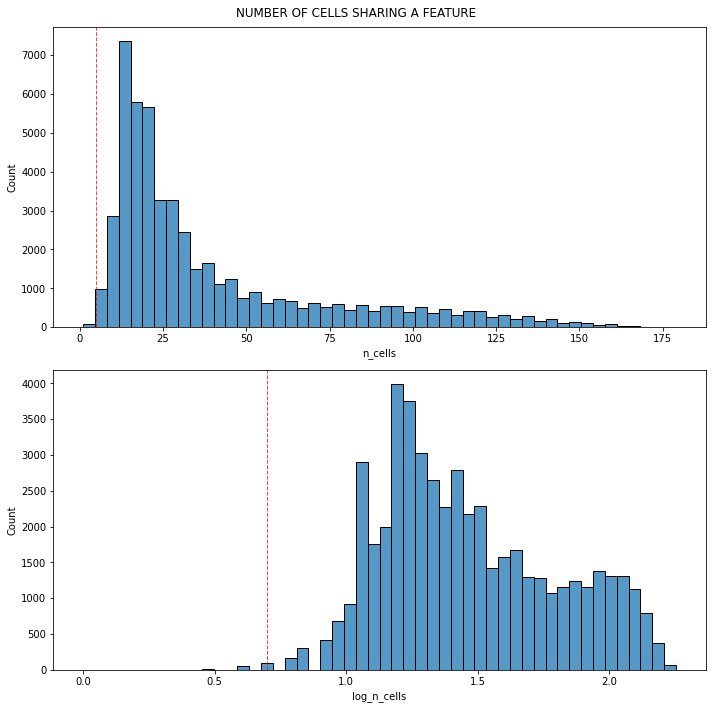

In [16]:
min_cells = 5

nrows = 2
ncols = 1

fig, axs = plt.subplots(figsize=(ncols * 10, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

fig.suptitle("NUMBER OF CELLS SHARING A FEATURE")

sns.histplot(adata_atac.var.n_cells, bins=50, ax=axs[0])
axs[0].axvline(x=min_cells, color="red", linestyle="--", linewidth=1, alpha=0.75)

sns.histplot(adata_atac.var.log_n_cells, bins=50, ax=axs[1])
axs[1].axvline(x=np.log10(min_cells), color="red", linestyle="--", linewidth=1, alpha=0.75)

plt.tight_layout()
plt.savefig(fig_dir + "atac_qc_hist_n_cells.png", dpi=300)

In [17]:
print(adata_atac.n_vars)
adata_atac = adata_atac[:, ~(adata_atac.var.n_cells < min_cells)].copy()
print(adata_atac.n_vars)

50535
50457


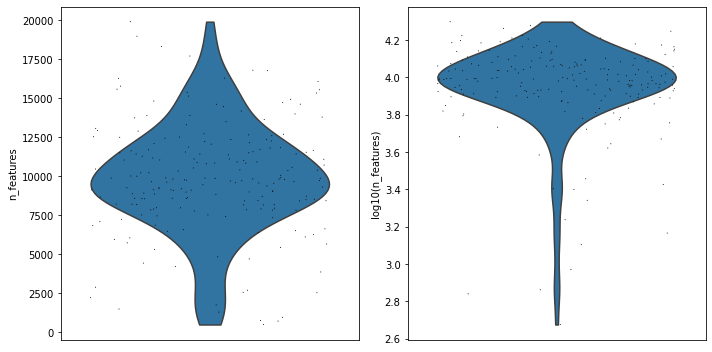

In [18]:
nrows = 1
ncols = 2

fig, axs = plt.subplots(figsize=(ncols * 5, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

sns.violinplot(y=adata_atac.obs.n_features, inner=None, cut=0, ax=axs[0])
sns.stripplot(y=adata_atac.obs.n_features, size=1, jitter=0.4, color="black", ax=axs[0])
axs[0].set_xticks([])
axs[0].set_ylabel("n_features")

sns.violinplot(y=adata_atac.obs.log_n_features, inner=None, cut=0, ax=axs[1])
sns.stripplot(y=adata_atac.obs.log_n_features, size=1, jitter=0.4, color="black", ax=axs[1])
axs[1].set_xticks([])
axs[1].set_ylabel("log10(n_features)")

plt.tight_layout()
plt.savefig(fig_dir + "atac_qc_violin_after_filtering.png", dpi=300) 

<br><br><br><hr><br><br><br>

In [19]:
adata_atac.obs["n_peaks_col1a1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))
adata_atac.obs["n_peaks_col1a2"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A2")].sum(axis=1))
adata_atac.obs["n_peaks_col5a1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL5A1")].sum(axis=1))
adata_atac.obs["n_peaks_loxl1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOXL1")].sum(axis=1))
adata_atac.obs["n_peaks_lum"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))
adata_atac.obs["n_peaks_fbln1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN1")].sum(axis=1))
adata_atac.obs["n_peaks_fbln2"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN2")].sum(axis=1))
adata_atac.obs["n_peaks_cd34"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD34")].sum(axis=1))
adata_atac.obs["n_peaks_pdgfra"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRA")].sum(axis=1))

adata_atac.obs["n_peaks_vim"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VIM")].sum(axis=1))
adata_atac.obs["n_peaks_col6a2"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL6A2")].sum(axis=1))
adata_atac.obs["n_peaks_cela1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CELA1")].sum(axis=1))
adata_atac.obs["n_peaks_pdgfrb"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRB")].sum(axis=1))
adata_atac.obs["n_peaks_vtn"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VTN")].sum(axis=1))
adata_atac.obs["n_peaks_lum"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))
adata_atac.obs["n_peaks_postn"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("POSTN")].sum(axis=1))
adata_atac.obs["n_peaks_col1a1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))
adata_atac.obs["n_peaks_lox"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOX")].sum(axis=1))

In [20]:
adata_atac.obs["n_peaks_epcam"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))
adata_atac.obs["n_peaks_krt20"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT20")].sum(axis=1))
adata_atac.obs["n_peaks_krt14"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))

adata_atac.obs["n_peaks_krt14"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))
adata_atac.obs["n_peaks_muc1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("MUC1")].sum(axis=1))
adata_atac.obs["n_peaks_epcam"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))
adata_atac.obs["n_peaks_krt3"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT3")].sum(axis=1))
adata_atac.obs["n_peaks_anpep"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("ANPEP")].sum(axis=1))
adata_atac.obs["n_peaks_scgb1a1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("SCGB1A1")].sum(axis=1))
adata_atac.obs["n_peaks_cldn1"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CLDN1")].sum(axis=1))
adata_atac.obs["n_peaks_ocln"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("OCLN")].sum(axis=1))
adata_atac.obs["n_peaks_cd24"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD24")].sum(axis=1))

In [21]:
adata_atac.obs["n_peaks_fibroblasts"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A2")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL5A1")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOXL1")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN1")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN2")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD34")].sum(axis=1))
adata_atac.obs["n_peaks_fibroblasts"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRA")].sum(axis=1))

adata_atac.obs["n_peaks_epithelial"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))
adata_atac.obs["n_peaks_epithelial"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT20")].sum(axis=1))
adata_atac.obs["n_peaks_epithelial"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))

In [22]:
adata_atac.obs["peaks_fibroblasts"] = np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A2")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL5A1")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOXL1")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN1")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("FBLN2")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD34")].sum(axis=1))])
adata_atac.obs["peaks_fibroblasts"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRA")].sum(axis=1))])


adata_atac.obs["peaks_epithelial"] = np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))])
adata_atac.obs["peaks_epithelial"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT20")].sum(axis=1))])
adata_atac.obs["peaks_epithelial"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))])

In [23]:
adata_atac.obs["fib_markers_quant"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VIM")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL6A2")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CELA1")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRB")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VTN")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("POSTN")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))
adata_atac.obs["fib_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOX")].sum(axis=1))

adata_atac.obs["epithelial_markers_quant"] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("MUC1")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT3")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("ANPEP")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("SCGB1A1")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CLDN1")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("OCLN")].sum(axis=1))
adata_atac.obs["epithelial_markers_quant"] += np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD24")].sum(axis=1))

In [24]:
adata_atac.obs["fib_markers_non_quant"] = np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VIM")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL6A2")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CELA1")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("PDGFRB")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("VTN")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LUM")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("POSTN")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("COL1A1")].sum(axis=1))])
adata_atac.obs["fib_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("LOX")].sum(axis=1))])


adata_atac.obs["epithelial_markers_non_quant"] = np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT14")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("MUC1")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("EPCAM")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("KRT3")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("ANPEP")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("SCGB1A1")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CLDN1")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("OCLN")].sum(axis=1))])
adata_atac.obs["epithelial_markers_non_quant"] += np.array([1 if v != 0 else 0 for v in np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("CD24")].sum(axis=1))])

<br><br><br><hr><h2>FEATURE SELECTION</h2>

In [25]:
adata_atac.var["prop_shared_cells"] = adata_atac.var.n_cells / adata_atac.n_obs
adata_atac.var["variability_score"] = 1 - np.abs(adata_atac.var.prop_shared_cells - 0.5)

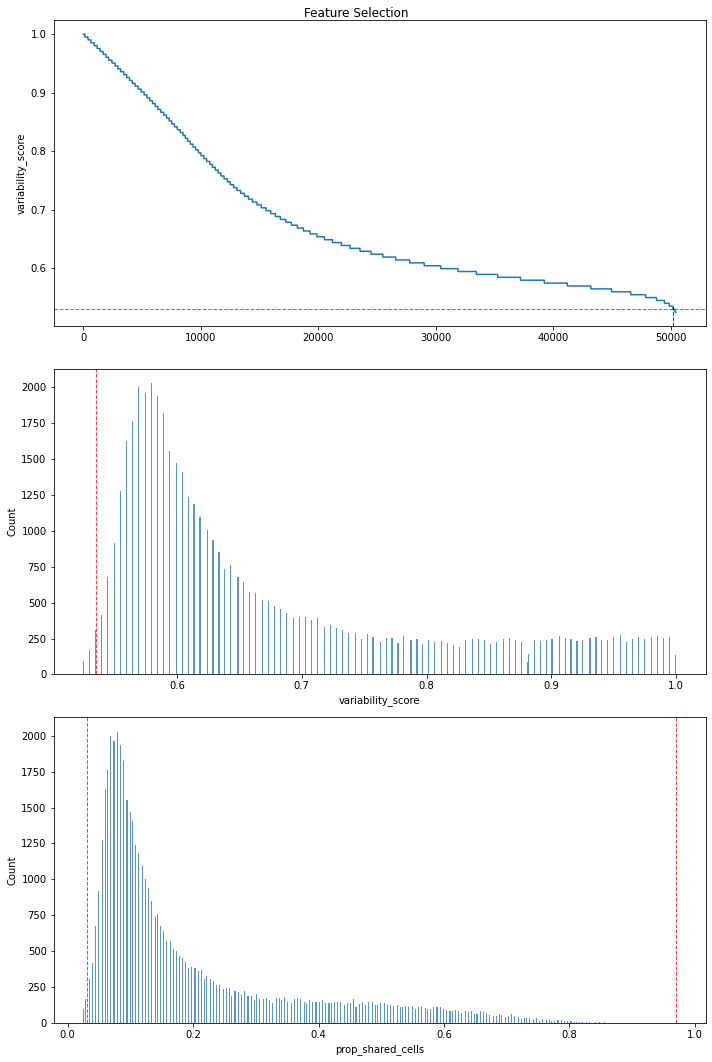

In [26]:
n_bins = 500
min_score = 0.53
n_features_selected = None

if min_score is None:
    tmp = adata_atac.var.nlargest(n_features_selected, columns="variability_score")
else:
    tmp = adata_atac.var[adata_atac.var.variability_score >= min_score]
    n_features_selected = tmp.shape[0]

min_var_score = tmp.variability_score.min()
max_var_score = tmp.variability_score.max()

min_prop_shared = tmp.prop_shared_cells.min()
max_prop_shared = tmp.prop_shared_cells.max()

nrows = 3
ncols = 1

fig, axs = plt.subplots(figsize=(ncols * 10, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

fig.suptitle("Feature Selection")

sns.lineplot(x=np.arange(1, adata_atac.n_vars + 1), y=adata_atac.var.variability_score.sort_values(ascending=False), ax=axs[0])
if min_score is None:
    axs[0].axvline(x=n_features_selected, color="red", linestyle="--", linewidth=1, alpha=0.75)
    lims = axs[0].get_xlim()
    axs[0].hlines(y=min_var_score, xmin=lims[0], xmax=n_features_selected, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[0].set_xlim(lims)
else:
    axs[0].axhline(y=min_score, color="red", linestyle="--", linewidth=1, alpha=0.75)
    lims = axs[0].get_ylim()
    axs[0].vlines(x=n_features_selected, ymin=lims[0], ymax=min_var_score, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[0].set_ylim(lims)

sns.histplot(adata_atac.var.variability_score, bins=n_bins, linewidth=0, ax=axs[1])
if min_score is None:
    axs[1].axvline(x=min_var_score, color="black", linestyle="--", linewidth=1, alpha=0.75)
else:
    axs[1].axvline(x=min_var_score, color="red", linestyle="--", linewidth=1, alpha=0.75)

sns.histplot(adata_atac.var.prop_shared_cells, bins=n_bins, linewidth=0, ax=axs[2])
if min_score is None:
    axs[2].axvline(x=min_prop_shared, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[2].axvline(x=max_prop_shared, color="black", linestyle="--", linewidth=1, alpha=0.75)
else:
    axs[2].axvline(x=min_score - 0.5, color="red", linestyle="--", linewidth=1, alpha=0.75)
    axs[2].axvline(x=1 - (min_score - 0.5), color="red", linestyle="--", linewidth=1, alpha=0.75)

plt.tight_layout()
plt.savefig(fig_dir + "atac_feature_selection_most_var_{}.png".format(n_features_selected), dpi=300)

In [27]:
adata_atac = adata_atac[:, adata_atac.var.variability_score >= min_var_score].copy()
print(adata_atac)

AnnData object with n_obs × n_vars = 202 × 50195
    obs: 'n_features', 'log_n_features', 'tss_enrichment_score', 'tss_high', 'n_peaks_col1a1', 'n_peaks_col1a2', 'n_peaks_col5a1', 'n_peaks_loxl1', 'n_peaks_lum', 'n_peaks_fbln1', 'n_peaks_fbln2', 'n_peaks_cd34', 'n_peaks_pdgfra', 'n_peaks_vim', 'n_peaks_col6a2', 'n_peaks_cela1', 'n_peaks_pdgfrb', 'n_peaks_vtn', 'n_peaks_postn', 'n_peaks_lox', 'n_peaks_epcam', 'n_peaks_krt20', 'n_peaks_krt14', 'n_peaks_muc1', 'n_peaks_krt3', 'n_peaks_anpep', 'n_peaks_scgb1a1', 'n_peaks_cldn1', 'n_peaks_ocln', 'n_peaks_cd24', 'n_peaks_fibroblasts', 'n_peaks_epithelial', 'peaks_fibroblasts', 'peaks_epithelial', 'fib_markers_quant', 'epithelial_markers_quant', 'fib_markers_non_quant', 'epithelial_markers_non_quant'
    var: 'transcript_annotation', 'gene_annotation', 'n_cells', 'log_n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'tss_enrichment'


<br><br><br><hr><h2>NORMALIZATION ETC</h2>

In [28]:
print("n features mean:\t{}".format(np.mean(np.ravel(adata_atac.X.sum(axis=1)))))
print("n features median:\t{}".format(np.median(np.ravel(adata_atac.X.sum(axis=1)))))

n features mean:	9834.322265625
n features median:	9767.0


In [29]:
sc.pp.normalize_total(adata_atac)

In [30]:
epi.pp.log1p(adata_atac)

<br><br><br><hr><h2>EMBEDDING</h2>

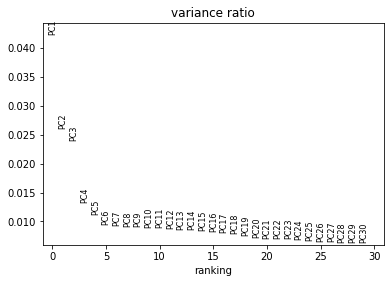

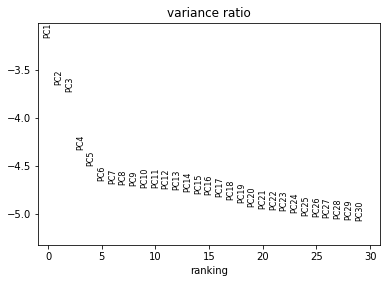

In [31]:
epi.pp.pca(adata_atac, n_comps=30, svd_solver="arpack")
epi.pl.pca_variance_ratio(adata_atac)
epi.pl.pca_variance_ratio(adata_atac, log=True)

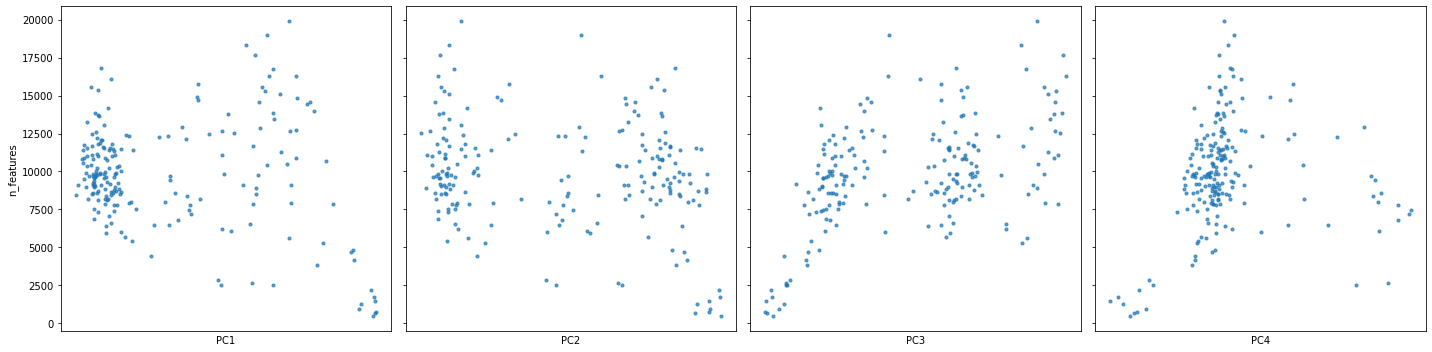

In [32]:
pl_pc_nfeat_corr(adata_atac, pcs=4, key="n_features", save="{}atac_pc_nfeat_corr_most_var_{}.png".format(fig_dir, n_features_selected))

In [33]:
epi.pp.pca(adata_atac, n_comps=5, svd_solver="arpack")

In [34]:
# print(adata_atac.obsm["X_pca"].shape)
# adata_atac.obsm["X_pca"] = np.delete(adata_atac.obsm["X_pca"], 0, 1)
# print(adata_atac.obsm["X_pca"].shape)

In [35]:
epi.pp.neighbors(adata_atac, n_neighbors=15, metric="euclidean", method="umap")
epi.tl.umap(adata_atac)

2022-01-26 15:53:35.769346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


... storing 'tss_high' as categorical
... storing 'transcript_annotation' as categorical
... storing 'gene_annotation' as categorical


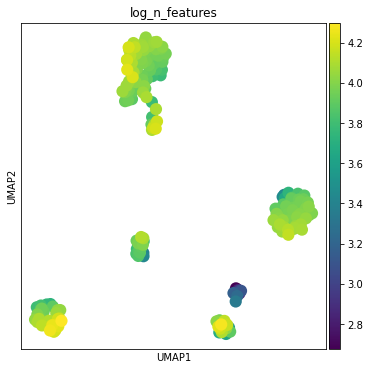

In [36]:
plt.rcParams["figure.figsize"]= (6, 6)
sc.pl.umap(adata_atac, color=["log_n_features"], ncols=2, save="_atac_emb_most_var_{}.png".format(n_features_selected))

<br><br><br><hr><br><br><br>

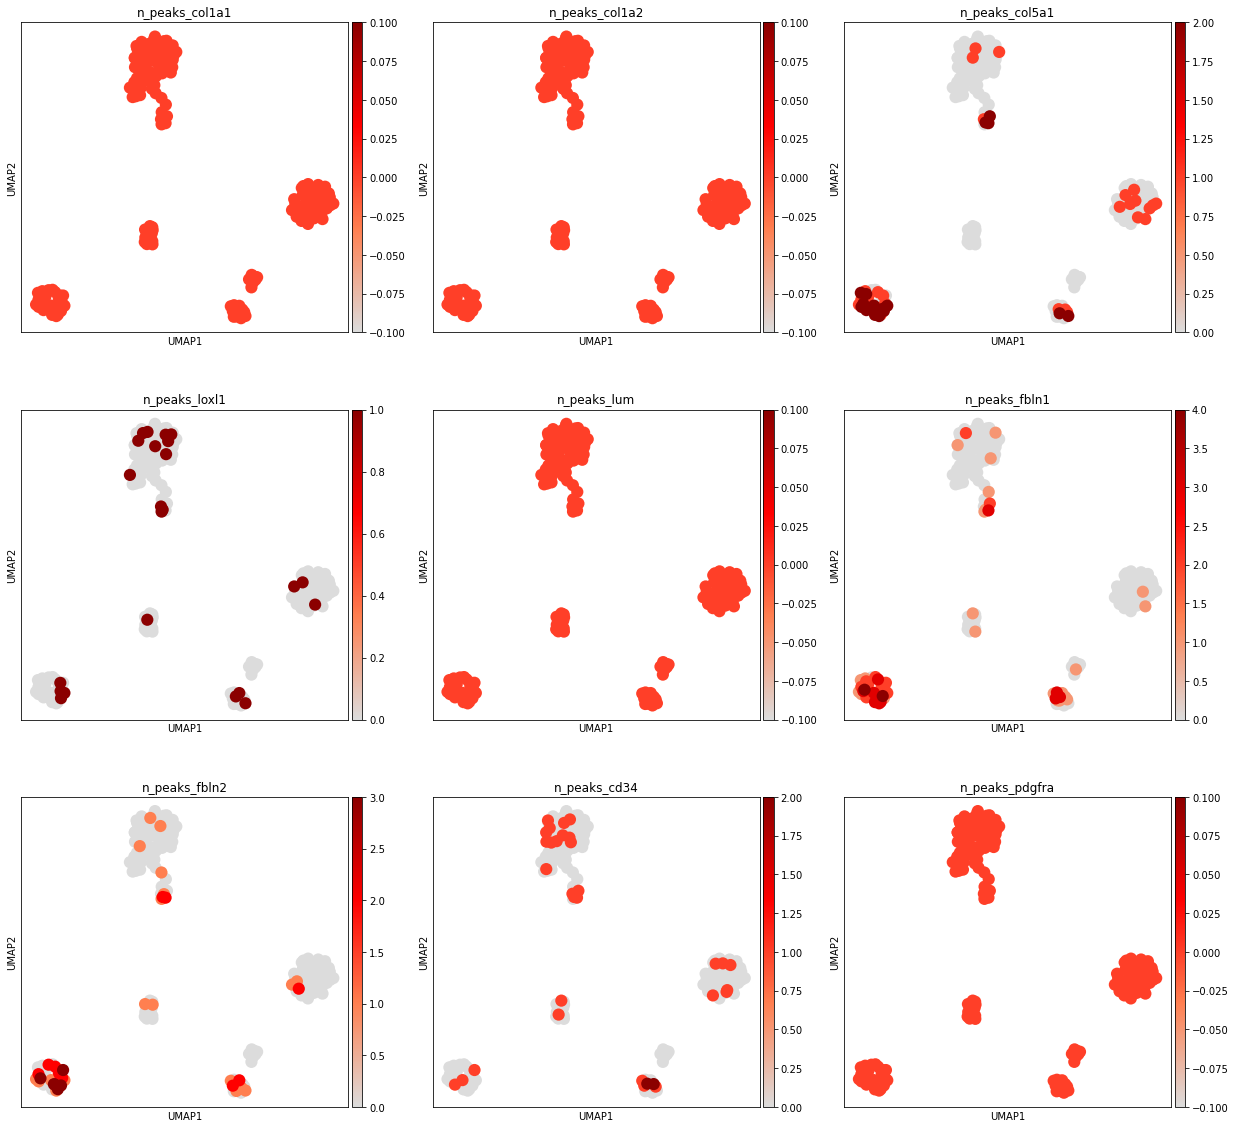

In [37]:
sc.pl.umap(adata_atac, color=["n_peaks_col1a1", "n_peaks_col1a2", "n_peaks_col5a1", "n_peaks_loxl1", "n_peaks_lum", "n_peaks_fbln1", "n_peaks_fbln2", "n_peaks_cd34", "n_peaks_pdgfra"], ncols=3, color_map=cmap, save="_atac_emb_most_var_{}_fib_markers.png".format(n_features_selected))

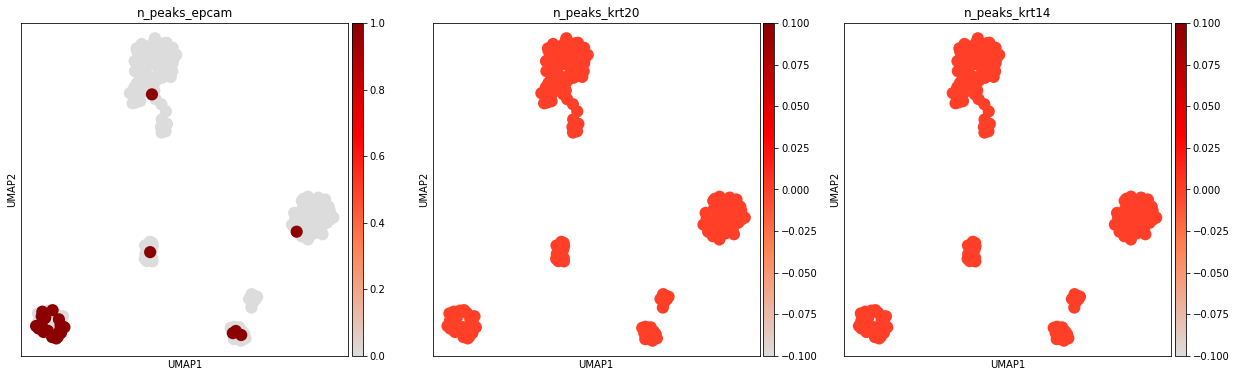

In [38]:
sc.pl.umap(adata_atac, color=["n_peaks_epcam", "n_peaks_krt20", "n_peaks_krt14"], ncols=3, color_map=cmap, save="_atac_emb_most_var_{}_endo_markers.png".format(n_features_selected))

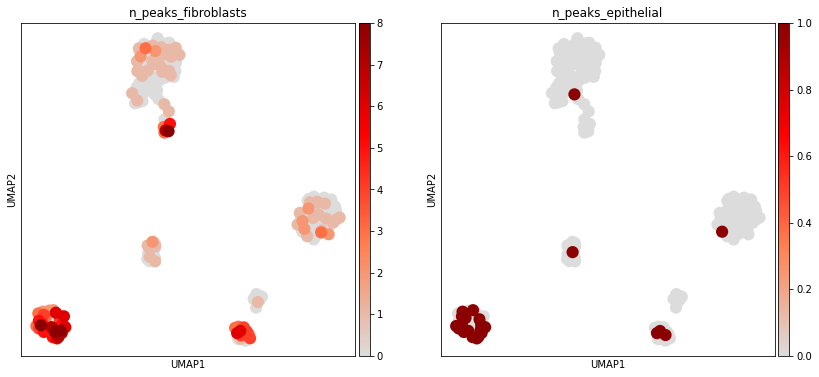

In [39]:
sc.pl.umap(adata_atac, color=["n_peaks_fibroblasts", "n_peaks_epithelial"], ncols=3, color_map=cmap, save="_atac_emb_most_var_{}_marker_summary_quantitative.png".format(n_features_selected))

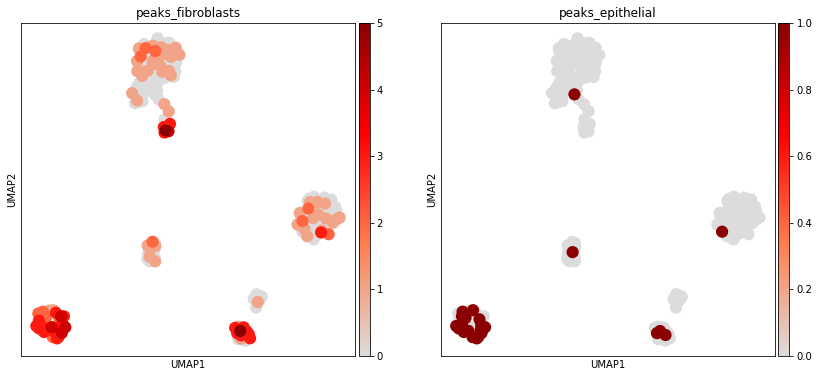

In [40]:
sc.pl.umap(adata_atac, color=["peaks_fibroblasts", "peaks_epithelial"], ncols=3, color_map=cmap, save="_atac_emb_most_var_{}_marker_summary_non-quant.png".format(n_features_selected))

<br><br><br><hr><br><br><br>

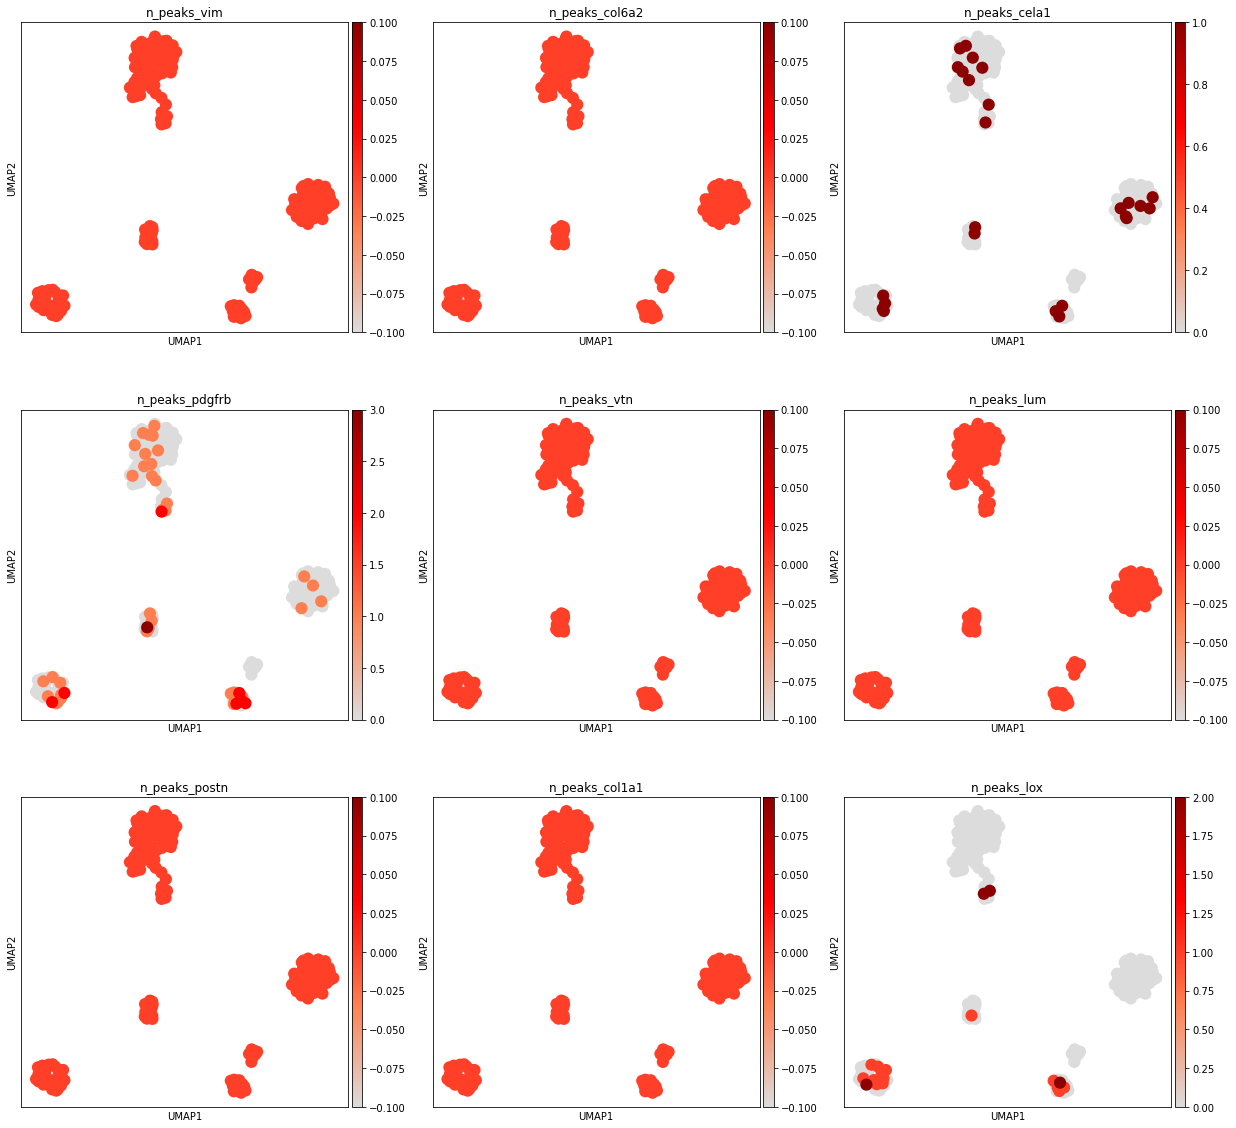

In [41]:
sc.pl.umap(adata_atac, color=["n_peaks_vim", "n_peaks_col6a2", "n_peaks_cela1", "n_peaks_pdgfrb", "n_peaks_vtn", "n_peaks_lum", "n_peaks_postn", "n_peaks_col1a1", "n_peaks_lox"], ncols=3, save="_atac_emb_most_var_{}_fib_markers_new.png".format(n_features_selected), color_map=cmap)

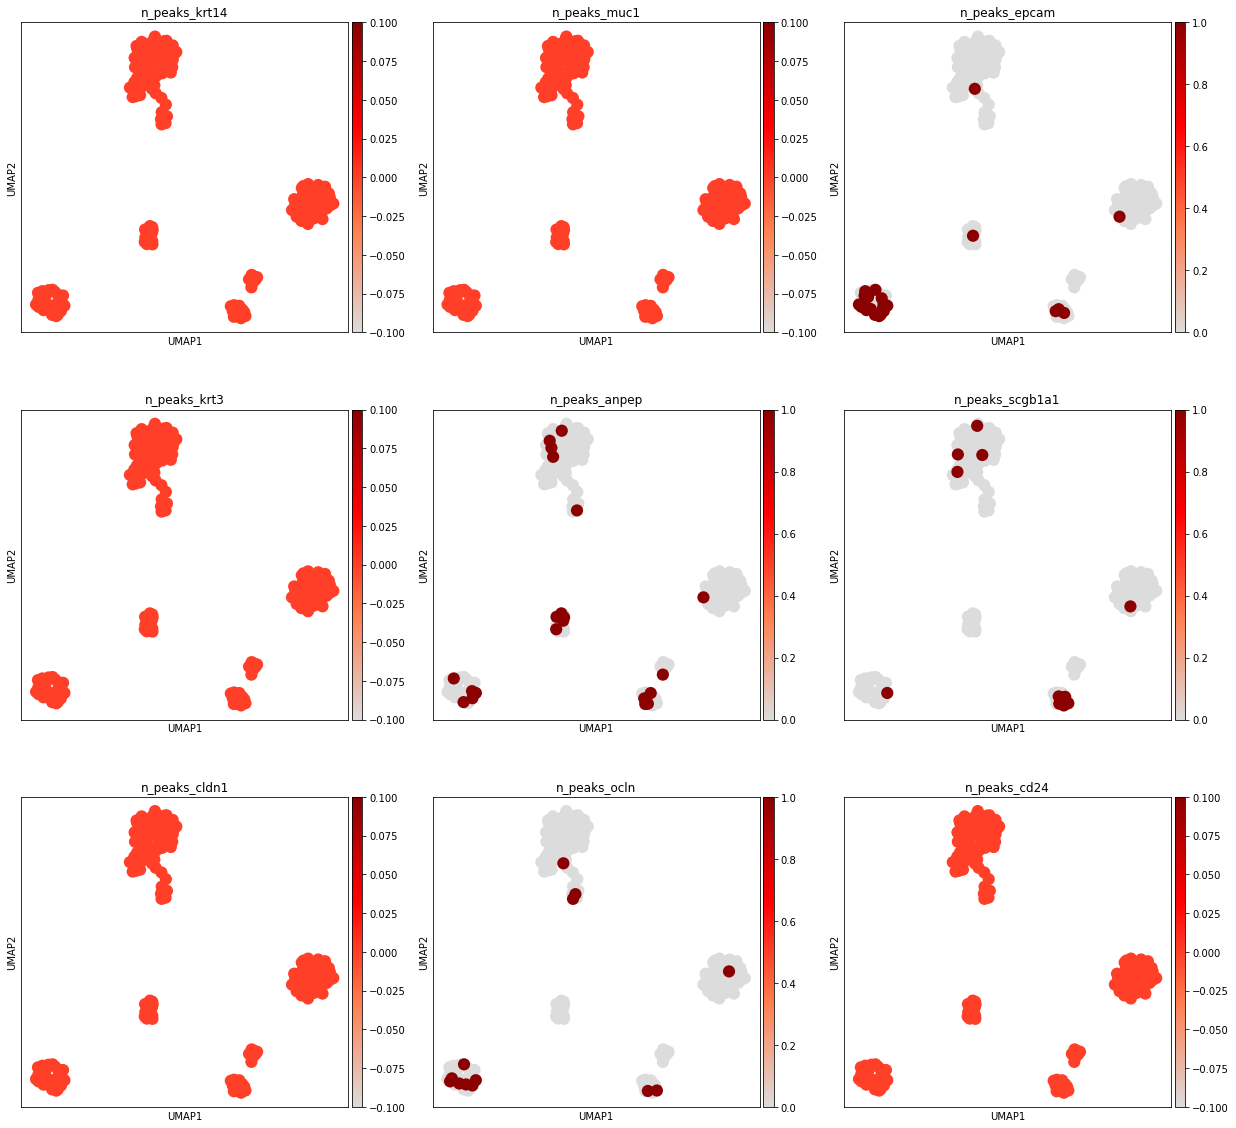

In [42]:
sc.pl.umap(adata_atac, color=["n_peaks_krt14", "n_peaks_muc1", "n_peaks_epcam", "n_peaks_krt3", "n_peaks_anpep", "n_peaks_scgb1a1", "n_peaks_cldn1", "n_peaks_ocln", "n_peaks_cd24"], ncols=3, save="_atac_emb_most_var_{}_epithelial_markers_new.png".format(n_features_selected), color_map=cmap)

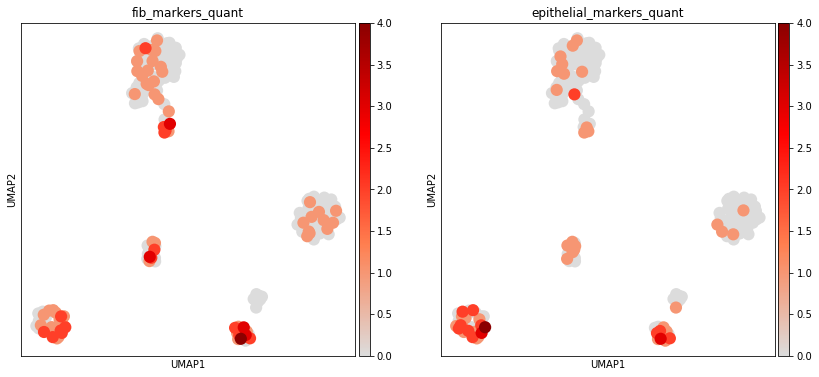

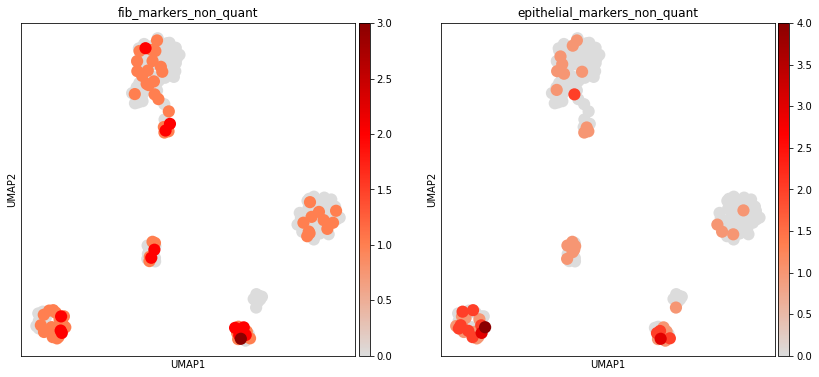

In [43]:
sc.pl.umap(adata_atac, color=["fib_markers_quant", "epithelial_markers_quant"], ncols=3, save="_atac_emb_most_var_{}_marker_summary_quant.png".format(n_features_selected), color_map=cmap)
sc.pl.umap(adata_atac, color=["fib_markers_non_quant", "epithelial_markers_non_quant"], ncols=3, save="_atac_emb_most_var_{}_marker_summary_non_quant.png".format(n_features_selected), color_map=cmap)

<br><br><br><hr><br><br><br>

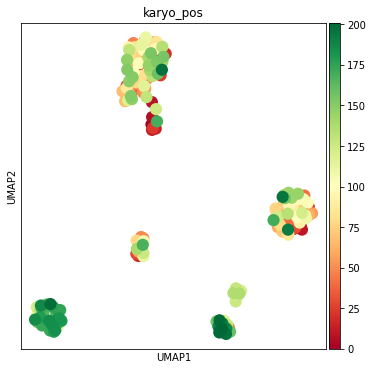

In [44]:
adata_atac.obs["karyo_pos"] = [list_of_barcodes.bc[list_of_barcodes.bc == bc].index[0] for bc in adata_atac.obs.index if bc in list_of_barcodes.bc.values]
sc.pl.umap(adata_atac, color=["karyo_pos"], ncols=3, save="_atac_emb_most_var_{}_filtered_karyo_pos.png".format(n_features_selected), color_map="RdYlGn")

<br><br><br><hr><br><br><br>

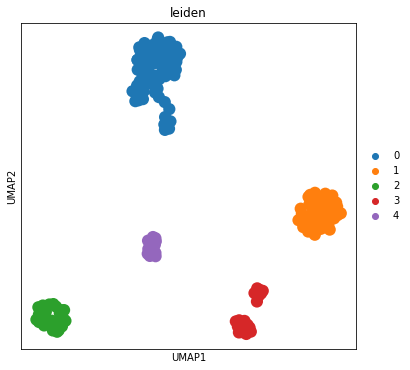

In [45]:
epi.tl.leiden(adata_atac, resolution=0.2)
sc.pl.umap(adata_atac, color=["leiden"], ncols=2, save="_atac_emb_most_var_{}_leiden.png".format(n_features_selected))

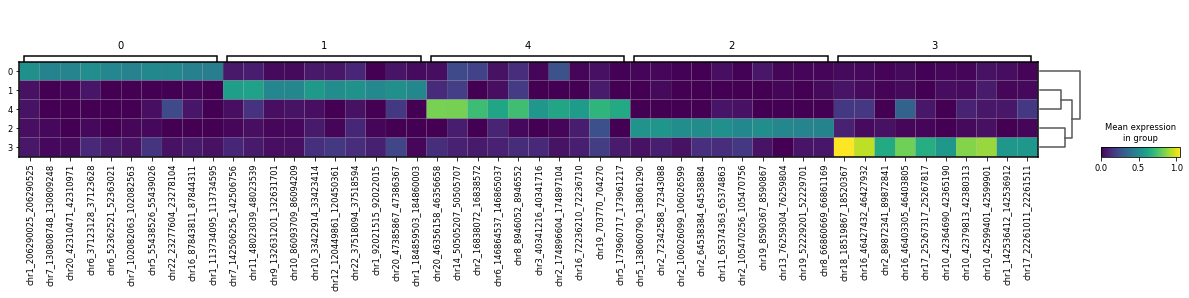

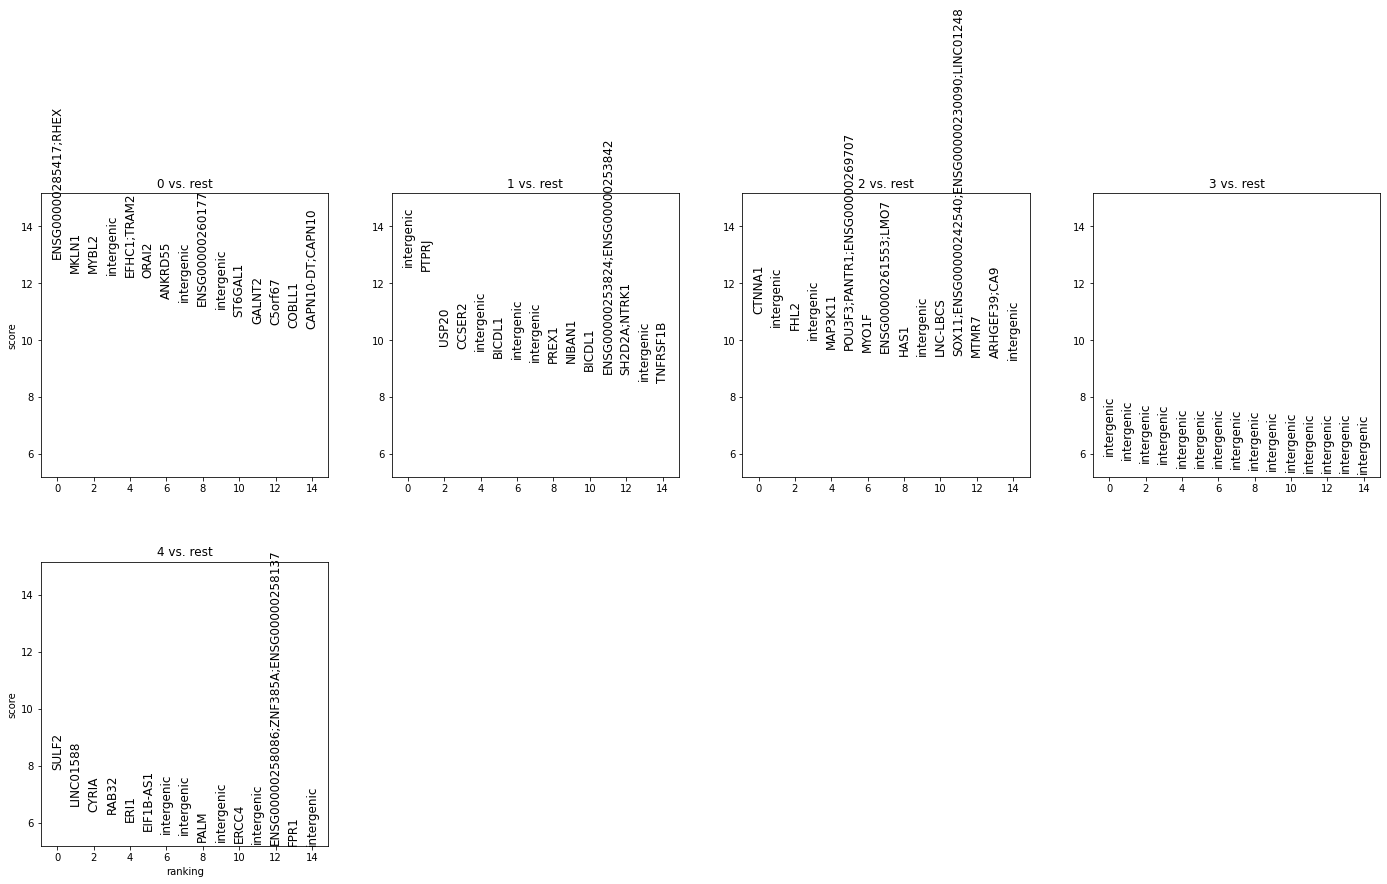

In [46]:
# del adata_atac.uns["dendrogram_leiden"]
epi.tl.rank_features(adata_atac, 'leiden', omic='ATAC', use_raw=False)
epi.pl.rank_feat_groups_matrixplot(adata_atac, save="_{}.png".format(n_features_selected))
epi.pl.rank_feat_groups(adata_atac, feature_symbols='gene_annotation', n_features=15, ncols=4, fontsize=12, save="_annotation_{}.png".format(n_features_selected))

In [47]:
groups = np.sort(adata_atac.obs[adata_atac.uns["rank_features_groups"]["params"]["groupby"]].unique().to_numpy())
regions_per_group = [(group, [region.replace("_", "\t") for region in adata_atac.uns["rank_features_groups"]["names"][group]]) for group in groups]

In [48]:
for group, regions in regions_per_group:
    with open("{}{}_regions_group_{}.bed".format(base_dir, name, group), "w") as fh:
        for region in regions:
            fh.write("{}\n".format(region))

In [49]:
for group, regions in regions_per_group:
    with open("{}{}_regions_group_{}_top50.bed".format(base_dir, name, group), "w") as fh:
        for region in regions[:50]:
            fh.write("{}\n".format(region))

<br><br><br><hr><br><br><br>

In [50]:
with open("{}{}_clusters.pickle".format(base_dir, name), "wb") as fh:
    pickle.dump({k: v for k, v in zip(adata_atac.obs_names, adata_atac.obs.leiden)}, fh)

In [51]:
with open("{}{}_clusters.pickle".format(base_dir, name), "rb") as fh:
    cluster_per_barcode = pickle.load(fh)
    
# cluster_per_barcode

In [52]:
tmp = pd.DataFrame({"barcode": adata_atac.obs_names.values, "cluster_id": adata_atac.obs.leiden.values})
tmp.to_csv("{}{}_clusters.csv".format(base_dir, name), index=False)